In [1]:
# how many emotions categories

import os
import cv2
import numpy as np
from tensorflow.keras.utils import to_categorical

INPUT_PATH = "../processed_dataset_size224/"
EMOTIONS = [
    f.name for f in os.scandir(INPUT_PATH) 
    if f.is_dir() 
    and not f.name.startswith('.')               # 排除所有以 '.' 开头的隐藏目录
]
IMAGE_SIZE = (48, 48)

print(EMOTIONS)

2024-12-23 16:41:02.894119: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-23 16:41:03.084424: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-23 16:41:03.904958: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /root/miniconda3/lib/python3.8/site-packages/cv2/../../lib64:/usr/local/nvidia/lib:/usr

['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']


In [2]:
import os
import cv2
import numpy as np
from tensorflow.keras.utils import to_categorical

VALID_EXTENSIONS = ('.jpg', '.png')

def image_generator(input_path, emotions, image_size):
    for index, emotion in enumerate(emotions):
        emotion_path = os.path.join(input_path, emotion)
        if not os.path.isdir(emotion_path):
            print(f"目录不存在: {emotion_path}")
            continue
        for filename in os.listdir(emotion_path):
            if not filename.lower().endswith(VALID_EXTENSIONS):
                print(f"跳过非图像文件: {filename}")
                continue
            file_path = os.path.join(input_path, emotion, filename)
            # print(f"正在加载图像: {file_path}")
            img = cv2.imread(file_path)
            if img is None:
                print(f"无法读取图像: {file_path}")
                continue
            try:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # 转换为灰度图
            except Exception as e:
                print(f"颜色转换失败: {file_path}, 错误: {e}")
                continue
            try:
                img = cv2.resize(img, image_size)  # 调整图像大小
                img = np.expand_dims(img, axis=-1)  # 添加通道维度 (height, width, 1)
            except Exception as e:
                print(f"调整大小失败: {file_path}, 错误: {e}")
                continue
            img = img.astype('float32') / 255.0  # 归一化
            yield img, index

def load_images(input_path, emotions, image_size):
    X, y = [], []
    for img, label in image_generator(input_path, emotions, image_size):
        X.append(img)
        y.append(label)
    X = np.array(X)
    y = to_categorical(np.array(y))  # 将标签进行独热编码
    return X, y


In [3]:
# Load the images
X, y = load_images(INPUT_PATH, EMOTIONS, IMAGE_SIZE)
input_shape = X[0].shape
print(f"input_shape:{X[0].shape}")
#input_shape = (48,48,3) 

input_shape:(48, 48, 1)


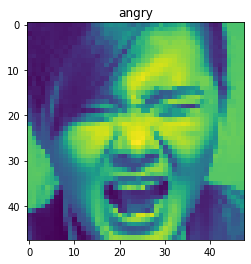

In [4]:
import matplotlib.pyplot as plt

# choose a random image index
idx = np.random.randint(len(X))

# display the image and its corresponding label from arrays
plt.imshow(X[idx])
plt.title(EMOTIONS[np.argmax(y[idx])])
plt.show()

In [5]:
# Train test split pre-processed data

from sklearn.model_selection import StratifiedShuffleSplit, train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dropout, BatchNormalization, Flatten, Dense, MaxPool2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

# 定义模型架构
model = Sequential()
input_shape = (48, 48, 1)  # 输入图像尺寸

# 1st convolution layer
model.add(Conv2D(32, (3,3), activation="selu", input_shape=input_shape, padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.3))

# 2nd convolution layer
model.add(Conv2D(64, (3,3), activation="selu", padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), activation="selu", padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.4))

# 3rd convolution layer
model.add(Conv2D(128, (3,3), activation="selu", padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), activation="selu", padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.5))

# 4th convolution layer
model.add(Conv2D(256, (3,3), activation="selu", padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(256, (3,3), activation="selu", padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.6))

# Flatten layer
model.add(Flatten())

# Fully connected neural networks
model.add(Dense(128, activation='selu', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Output layer with softmax activation
model.add(Dense(7, activation='softmax'))

# 编译模型
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# 打印模型摘要
model.summary()


2024-12-23 16:41:06.713746: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-23 16:41:07.456368: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20811 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:da:00.0, compute capability: 7.5


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 24, 24, 64)       2

In [7]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv2D, Dropout, BatchNormalization, Flatten, Dense, MaxPooling2D, AveragePooling2D
# from tensorflow.keras.regularizers import l2
# from tensorflow.keras.optimizers import Adam

# # 定义模型架构
# model = Sequential()
# num_classes = 7

# # 1st convolution layer
# model.add(Conv2D(64, (3, 3), activation="relu", input_shape=(48, 48, 1), padding='same'))
# model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# # 2nd convolution layer
# model.add(Conv2D(64, (3, 3), activation="relu", padding='same'))
# model.add(Conv2D(64, (3, 3), activation="relu", padding='same'))
# model.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2)))

# # 3rd convolution layer
# model.add(Conv2D(128, (3, 3), activation="relu", padding='same'))
# model.add(Conv2D(128, (3, 3), activation="relu", padding='same'))
# model.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2)))

# # 4th convolution layer (增加更多的卷积层)
# model.add(Conv2D(256, (3, 3), activation="relu", padding='same'))
# model.add(Conv2D(256, (3, 3), activation="relu", padding='same'))
# model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# # 5th convolution layer (进一步增加复杂性)
# model.add(Conv2D(512, (3, 3), activation="relu", padding='same'))
# model.add(Conv2D(512, (3, 3), activation="relu", padding='same'))
# model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# # Flatten layer
# model.add(Flatten())

# # Fully connected neural networks
# model.add(Dense(2048, activation="relu", kernel_regularizer=l2(0.01)))
# model.add(Dropout(0.4))  # 增加Dropout层来防止过拟合
# model.add(Dense(1024, activation="relu", kernel_regularizer=l2(0.01)))
# model.add(Dropout(0.4))
# model.add(Dense(1024, activation="relu", kernel_regularizer=l2(0.01)))
# model.add(Dropout(0.4))

# # 输出层
# model.add(Dense(num_classes, activation="softmax"))

# # 编译模型
# model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# # 打印模型摘要
# model.summary()


In [8]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

history = model.fit(X_train, y_train, batch_size=32,
                    epochs=100,
                    validation_data=(X_test, y_test),
                    
                    callbacks = [EarlyStopping(patience=10, monitor='val_loss', mode='min'), 
                                 ReduceLROnPlateau(monitor='val_loss', 
                                                   factor=0.5, 
                                                   patience=2, 
                                                   verbose=1),
                                 ModelCheckpoint('best_model_Gray.h5', 
                                                 save_best_only=True, 
                                                 save_weights_only=True, 
                                                 monitor='val_accuracy', 
                                                 mode='max')],
                    verbose=1)

Epoch 1/100


2024-12-23 16:41:11.303596: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-12-23 16:41:12.160077: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8101
2024-12-23 16:41:13.399917: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x55b7072f4e90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-12-23 16:41:13.399967: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2024-12-23 16:41:13.411555: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-23 16:41:13.568178: I tensorflow/compiler/jit/xla_compilation_cache.cc:4

23/23 [==============================] - 9s 54ms/step - loss: 5.3323 - accuracy: 0.2235 - val_loss: 7.8087 - val_accuracy: 0.1833 - lr: 0.0010
Epoch 2/100
23/23 [==============================] - 1s 24ms/step - loss: 5.1948 - accuracy: 0.1969 - val_loss: 8.5565 - val_accuracy: 0.1889 - lr: 0.0010
Epoch 3/100
23/23 [==============================] - 0s 22ms/step - loss: 4.8456 - accuracy: 0.2053 - val_loss: 4.6898 - val_accuracy: 0.2056 - lr: 0.0010
Epoch 4/100
23/23 [==============================] - 0s 21ms/step - loss: 4.5380 - accuracy: 0.2374 - val_loss: 4.6889 - val_accuracy: 0.2056 - lr: 0.0010
Epoch 5/100
23/23 [==============================] - 0s 21ms/step - loss: 4.3876 - accuracy: 0.2584 - val_loss: 5.3008 - val_accuracy: 0.1056 - lr: 0.0010
Epoch 6/100
21/23 [==========================>...] - ETA: 0s - loss: 4.2778 - accuracy: 0.2664
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
23/23 [==============================] - 0s 21ms/step - loss: 4.26

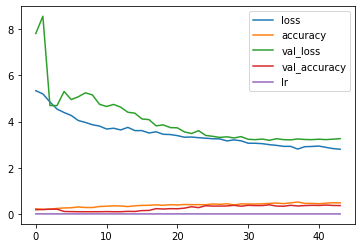

In [9]:
import pandas as pd

pd.DataFrame(history.history).plot();

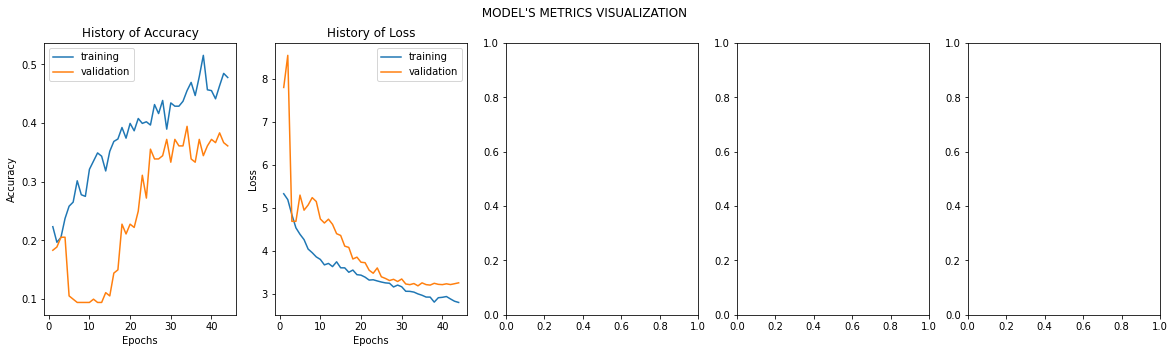

In [10]:
#%% PLOTTING RESULTS (Train vs Validation FOLDER 1)

def Train_Val_Plot(acc,val_acc,loss,val_loss):
    
    fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    

    plt.show()
    

Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'],
              )

6/6 [==============================] - 0s 5ms/step


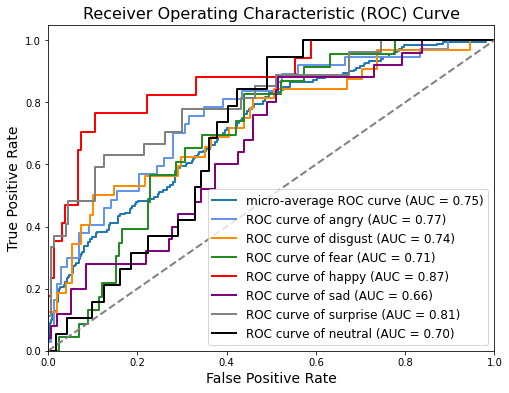

In [11]:
# calculates the false positive rate, true positive rate, and AUC score

from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

# Make predictions
y_pred = model.predict(X_test)

# Compute ROC curve and ROC AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(7):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC AUC score
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = roc_auc_score(y_test, y_pred, multi_class='ovr')

# Plot the ROC curves for each class and the micro-average ROC curve
plt.figure(figsize=(8, 6))
lw = 2
plt.plot(fpr["micro"], tpr["micro"], lw=lw, label='micro-average ROC curve (AUC = {0:0.2f})'
                                                   ''.format(roc_auc["micro"]))
colors = ['cornflowerblue', 'darkorange', 'forestgreen', 'red', 'purple', 'gray', 'black']
for i, color in zip(range(7), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of {0} (AUC = {1:0.2f})'.format(EMOTIONS[i], roc_auc[i]))
    
plt.plot([0, 1], [0, 1], color='gray', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.show()

In [12]:
# Compute classification report

from sklearn.metrics import classification_report

# Convert one-hot encoded y_test back to integers
y_test_int = np.argmax(y_test, axis=1)

# Make predictions
y_pred = model.predict(X_test)

# Convert one-hot encoded y_pred back to integers
y_pred_int = np.argmax(y_pred, axis=1)

# Generate classification report
print(classification_report(y_test_int, y_pred_int))

6/6 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

           0       0.50      0.32      0.39        37
           1       0.42      0.44      0.43        32
           2       0.00      0.00      0.00        23
           3       0.33      0.82      0.47        17
           4       0.38      0.12      0.18        25
           5       0.40      0.63      0.49        27
           6       0.19      0.26      0.22        19

    accuracy                           0.36       180
   macro avg       0.32      0.37      0.31       180
weighted avg       0.34      0.36      0.32       180



In [13]:
# Compute classification report

from sklearn.metrics import classification_report

# Convert one-hot encoded y_test back to integers
y_test_int = np.argmax(y_test, axis=1)

# Make predictions
y_pred = model.predict(X_test)

# Convert one-hot encoded y_pred back to integers
y_pred_int = np.argmax(y_pred, axis=1)

# Generate classification report
print(classification_report(y_test_int, y_pred_int))

6/6 [==============================] - 0s 5ms/step
              precision    recall  f1-score   support

           0       0.50      0.32      0.39        37
           1       0.42      0.44      0.43        32
           2       0.00      0.00      0.00        23
           3       0.33      0.82      0.47        17
           4       0.38      0.12      0.18        25
           5       0.40      0.63      0.49        27
           6       0.19      0.26      0.22        19

    accuracy                           0.36       180
   macro avg       0.32      0.37      0.31       180
weighted avg       0.34      0.36      0.32       180



In [14]:
# # save the model
# model.save('./best_model_class7.h5')